<a href="https://colab.research.google.com/github/takukai0605/transformer/blob/main/%E4%BD%9C%E3%81%A3%E3%81%A6%E7%90%86%E8%A7%A3%E3%81%99%E3%82%8Btransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

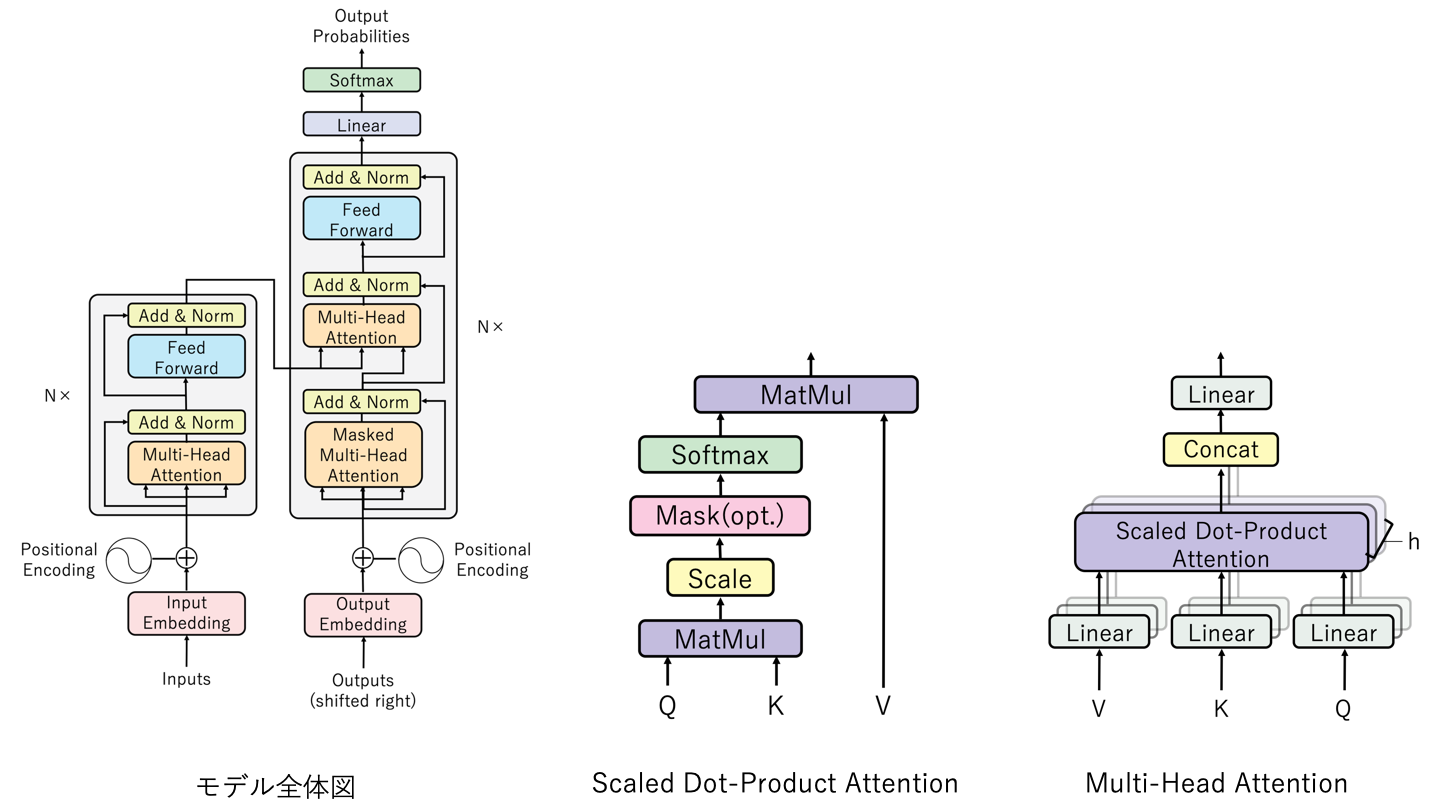

#初期設定

In [1]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.5 MB/s 


In [2]:
import tensorflow.compat.v1 as tf
import sentencepiece as spm
import numpy as np
import random
from typing import List, Sequence, Tuple
import os
import math

# 各パーツ

##TokenEmbedding

In [3]:
PAD_ID = 0


class TokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size: int, embedding_dim: int, dtype=tf.float32, *args, **kwargs):

        super().__init__(*args, **kwargs)#「tf.keras.layers.Layer」から「_init_」メソッドを呼び出して「*args, **kwargs」を代入
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dtype_ = dtype

    def build(self, input_shape: tf.TensorShape) -> None:
        self.lookup_table = self.add_variable(
            name='token_embedding',
            shape=[self.vocab_size, self.embedding_dim],
            dtype=self.dtype_,
            initializer=tf.random_normal_initializer(0., self.embedding_dim ** -0.5),
        )
        super().build(input_shape)

    def call(self, input: tf.Tensor) -> tf.Tensor:
        mask = tf.to_float(tf.not_equal(input, PAD_ID))
        embedding = tf.nn.embedding_lookup(self.lookup_table, input)
        embedding *= tf.expand_dims(mask, -1)  # 元々 PAD だった部分を0にする
        return embedding * self.embedding_dim ** 0.5

「super()」<br>
super()はここで言うTokenEmbedding()に代入したtf.keras.layers.Layerクラスのメソッド(defの部分)を呼び出す関数<br>
<br>
「 tf.keras.layers.Layer」<br>
多分、全結合のニューラルネットワークを作るライブラリ(よくわからん)<br>
<br>
「\*arg」<br>
複数の引数がタプル型として受け取られる<br>
<br>
「**kwargs」<br>
複数のキーワード引数を辞書として受け取る<br>




##AddPositionalEncoding

In [4]:
class AddPositionalEncoding(tf.keras.layers.Layer):
    '''
    入力テンソルに対し、位置の情報を付与して返すレイヤーです。
    see: https://arxiv.org/pdf/1706.03762.pdf

    PE_{pos, 2i}   = sin(pos / 10000^{2i / d_model})
    PE_{pos, 2i+1} = cos(pos / 10000^{2i / d_model})
    '''
    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        fl_type = inputs.dtype
        batch_size, max_length, depth = tf.unstack(tf.shape(inputs))

        depth_counter = tf.range(depth) // 2 * 2  # 0, 0, 2, 2, 4, ...
        depth_matrix = tf.tile(tf.expand_dims(depth_counter, 0), [max_length, 1])  # [max_length, depth]
        depth_matrix = tf.pow(10000.0, tf.cast(depth_matrix / depth, fl_type))  # [max_length, depth]

        # cos(x) == sin(x + π/2)
        phase = tf.cast(tf.range(depth) % 2, fl_type) * math.pi / 2  # 0, π/2, 0, π/2, ...
        phase_matrix = tf.tile(tf.expand_dims(phase, 0), [max_length, 1])  # [max_length, depth]

        pos_counter = tf.range(max_length)
        pos_matrix = tf.cast(tf.tile(tf.expand_dims(pos_counter, 1), [1, depth]), fl_type)  # [max_length, depth]

        positional_encoding = tf.sin(pos_matrix / depth_matrix + phase_matrix)
        # [batch_size, max_length, depth]
        positional_encoding = tf.tile(tf.expand_dims(positional_encoding, 0), [batch_size, 1, 1])

        return inputs + positional_encoding

## MultiheadAttention

In [5]:
class MultiheadAttention(tf.keras.models.Model):
    '''
    Multi-head Attention のモデルです。
    model = MultiheadAttention(
        hidden_dim=512,
        head_num=8,
        dropout_rate=0.1,
    )
    model(query, memory, mask, training=True)
    '''

    def __init__(self, hidden_dim: int, head_num: int, dropout_rate: float, *args, **kwargs):
        '''
        コンストラクタです。
        :param hidden_dim: 隠れ層及び出力の次元
            head_num の倍数である必要があります。
        :param head_num: ヘッドの数
        :param dropout_rate: ドロップアウトする確率
        '''
        super().__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.head_num = head_num
        self.dropout_rate = dropout_rate

        self.q_dense_layer = tf.keras.layers.Dense(hidden_dim, use_bias=False, name='q_dense_layer')
        self.k_dense_layer = tf.keras.layers.Dense(hidden_dim, use_bias=False, name='k_dense_layer')
        self.v_dense_layer = tf.keras.layers.Dense(hidden_dim, use_bias=False, name='v_dense_layer')
        self.output_dense_layer = tf.keras.layers.Dense(hidden_dim, use_bias=False, name='output_dense_layer')
        self.attention_dropout_layer = tf.keras.layers.Dropout(dropout_rate)

    def call(
            self,
            input: tf.Tensor,
            memory: tf.Tensor,
            attention_mask: tf.Tensor,
            training: bool,
    ) -> tf.Tensor:
        '''
        モデルの実行を行います。
        :param input: query のテンソル
        :param memory: query に情報を与える memory のテンソル
        :param attention_mask: attention weight に適用される mask
            shape = [batch_size, 1, q_length, k_length] のものです。
            pad 等無視する部分が True となるようなものを指定してください。
        :param training: 学習時か推論時かのフラグ
        '''
        q = self.q_dense_layer(input)  # [batch_size, q_length, hidden_dim]
        k = self.k_dense_layer(memory)  # [batch_size, m_length, hidden_dim]
        v = self.v_dense_layer(memory)

        q = self._split_head(q)  # [batch_size, head_num, q_length, hidden_dim/head_num]
        k = self._split_head(k)  # [batch_size, head_num, m_length, hidden_dim/head_num]
        v = self._split_head(v)  # [batch_size, head_num, m_length, hidden_dim/head_num]

        depth = self.hidden_dim // self.head_num
        q *= depth ** -0.5  # for scaled dot production

        # ここで q と k の内積を取ることで、query と key の関連度のようなものを計算します。
        logit = tf.matmul(q, k, transpose_b=True)  # [batch_size, head_num, q_length, k_length]
        logit += tf.to_float(attention_mask) * input.dtype.min  # mask は pad 部分などが1, 他は0

        # softmax を取ることで正規化します
        attention_weight = tf.nn.softmax(logit, name='attention_weight')
        attention_weight = self.attention_dropout_layer(attention_weight, training=training)

        # 重みに従って value から情報を引いてきます
        attention_output = tf.matmul(attention_weight, v)  # [batch_size, head_num, q_length, hidden_dim/head_num]
        attention_output = self._combine_head(attention_output)  # [batch_size, q_length, hidden_dim]
        return self.output_dense_layer(attention_output)

    def _split_head(self, x: tf.Tensor) -> tf.Tensor:
        '''
        入力の tensor の hidden_dim の次元をいくつかのヘッドに分割します。
        入力 shape: [batch_size, length, hidden_dim] の時
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        となります。
        '''
        with tf.name_scope('split_head'):
            batch_size, length, hidden_dim = tf.unstack(tf.shape(x))
            x = tf.reshape(x, [batch_size, length, self.head_num, self.hidden_dim // self.head_num])
            return tf.transpose(x, [0, 2, 1, 3])

    def _combine_head(self, x: tf.Tensor) -> tf.Tensor:
        '''
        入力の tensor の各ヘッドを結合します。 _split_head の逆変換です。
        入力 shape: [batch_size, head_num, length, hidden_dim//head_num] の時
        出力 shape: [batch_size, length, hidden_dim]
        となります。
        '''
        with tf.name_scope('combine_head'):
            batch_size, _, length, _ = tf.unstack(tf.shape(x))
            x = tf.transpose(x, [0, 2, 1, 3])
            return tf.reshape(x, [batch_size, length, self.hidden_dim])

##SelfAttention

In [6]:
class SelfAttention(MultiheadAttention):
    def call(  # type: ignore
            self,
            input: tf.Tensor,
            attention_mask: tf.Tensor,
            training: bool,
    ) -> tf.Tensor:
        return super().call(
            input=input,
            memory=input,
            attention_mask=attention_mask,
            training=training,
        )

##ResidualNormalizationWrapper



In [7]:
class ResidualNormalizationWrapper(tf.keras.models.Model):
    def __init__(self, layer: tf.keras.layers.Layer, dropout_rate: float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer = layer
        self.layer_normalization = LayerNormalization()
        self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

    def call(self, input: tf.Tensor, training: bool, *args, **kwargs) -> tf.Tensor:
        tensor = self.layer_normalization(input)
        tensor = self.layer(tensor, training=training, *args, **kwargs)
        tensor = self.dropout_layer(tensor, training=training)
        return input + tensor

##LayerNormalization

In [8]:
class LayerNormalization(tf.keras.layers.Layer):
    def build(self, input_shape: tf.TensorShape) -> None:
        hidden_dim = input_shape[-1]
        self.scale = self.add_weight('layer_norm_scale', shape=[hidden_dim],
                                     initializer=tf.ones_initializer())
        self.bias = self.add_weight('layer_norm_bias', [hidden_dim],
                                    initializer=tf.zeros_initializer())
        super().build(input_shape)

    def call(self, x: tf.Tensor, epsilon: float = 1e-6) -> tf.Tensor:
        mean = tf.reduce_mean(x, axis=[-1], keepdims=True)
        variance = tf.reduce_mean(tf.square(x - mean), axis=[-1], keepdims=True)
        norm_x = (x - mean) * tf.rsqrt(variance + epsilon)

        return norm_x * self.scale + self.bias

##FeedFowardNetwork

In [9]:
class FeedForwardNetwork(tf.keras.models.Model):
    '''
    Transformer 用の Position-wise Feedforward Neural Network です。
    '''
    def __init__(self, hidden_dim: int, dropout_rate: float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate

        self.filter_dense_layer = tf.keras.layers.Dense(hidden_dim * 4, use_bias=True,
                                                        activation=tf.nn.relu, name='filter_layer')
        self.output_dense_layer = tf.keras.layers.Dense(hidden_dim, use_bias=True, name='output_layer')
        self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

    def call(self, input: tf.Tensor, training: bool) -> tf.Tensor:
        '''
        FeedForwardNetwork を適用します。
        :param input: shape = [batch_size, length, hidden_dim]
        :return: shape = [batch_size, length, hidden_dim]
        '''
        tensor = self.filter_dense_layer(input)
        tensor = self.dropout_layer(tensor, training=training)
        return self.output_dense_layer(tensor)

##padded_cross_entropy_loss
##padded_accuracy
## _pad_tensors_to_same_length

In [10]:
def padded_cross_entropy_loss(logits, labels, smoothing, vocab_size):
    """Calculate cross entropy loss while ignoring padding.
    Args:
      logits: Tensor of size [batch_size, length_logits, vocab_size]
      labels: Tensor of size [batch_size, length_labels]
      smoothing: Label smoothing constant, used to determine the on and off values
      vocab_size: int size of the vocabulary
    Returns:
      Returns the cross entropy loss and weight tensors: float32 tensors with
        shape [batch_size, max(length_logits, length_labels)]
    """
    with tf.name_scope("loss", values=[logits, labels]):
        logits, labels = _pad_tensors_to_same_length(logits, labels)

        # Calculate smoothing cross entropy
        with tf.name_scope("smoothing_cross_entropy", values=[logits, labels]):
            confidence = 1.0 - smoothing
            low_confidence = (1.0 - confidence) / tf.to_float(vocab_size - 1)
            soft_targets = tf.one_hot(
                tf.cast(labels, tf.int32),
                depth=vocab_size,
                on_value=confidence,
                off_value=low_confidence)
            xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(
                logits=logits, labels=soft_targets)

            # Calculate the best (lowest) possible value of cross entropy, and
            # subtract from the cross entropy loss.
            normalizing_constant = -(
                confidence * tf.log(confidence) + tf.to_float(vocab_size - 1) *
                low_confidence * tf.log(low_confidence + 1e-20))
            xentropy -= normalizing_constant

        weights = tf.to_float(tf.not_equal(labels, 0))
        return xentropy * weights, weights


def padded_accuracy(logits, labels):
    """Percentage of times that predictions matches labels on non-0s."""
    with tf.variable_scope("padded_accuracy", values=[logits, labels]):
        logits, labels = _pad_tensors_to_same_length(logits, labels)
        weights = tf.to_float(tf.not_equal(labels, 0))
        outputs = tf.to_int32(tf.argmax(logits, axis=-1))
        padded_labels = tf.to_int32(labels)
        return tf.to_float(tf.equal(outputs, padded_labels)), weights


def _pad_tensors_to_same_length(x, y):
    """Pad x and y so that the results have the same length (second dimension)."""
    with tf.name_scope("pad_to_same_length"):
        x_length = tf.shape(x)[1]
        y_length = tf.shape(y)[1]

        max_length = tf.maximum(x_length, y_length)

        x = tf.pad(x, [[0, 0], [0, max_length - x_length], [0, 0]])
        y = tf.pad(y, [[0, 0], [0, max_length - y_length]])
        return x, y

#Transformer

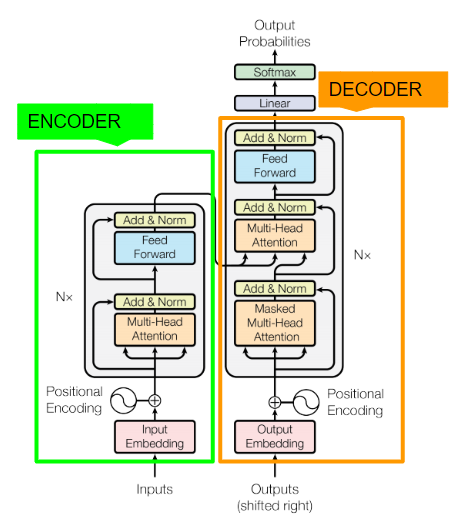

##Encoder

In [11]:
class Encoder(tf.keras.models.Model):
    '''
    トークン列をベクトル列にエンコードする Encoder です。
    '''
    def __init__(
            self,
            vocab_size: int,
            hopping_num: int,
            head_num: int,
            hidden_dim: int,
            dropout_rate: float,
            max_length: int,
            *args,
            **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.hopping_num = hopping_num
        self.head_num = head_num
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate

        self.token_embedding = TokenEmbedding(vocab_size, hidden_dim)
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = tf.keras.layers.Dropout(dropout_rate)

        self.attention_block_list: List[List[tf.keras.models.Model]] = []
        for _ in range(hopping_num):
            attention_layer = SelfAttention(hidden_dim, head_num, dropout_rate, name='self_attention')
            ffn_layer = FeedForwardNetwork(hidden_dim, dropout_rate, name='ffn')
            self.attention_block_list.append([
                ResidualNormalizationWrapper(attention_layer, dropout_rate, name='self_attention_wrapper'),
                ResidualNormalizationWrapper(ffn_layer, dropout_rate, name='ffn_wrapper'),
            ])
        self.output_normalization = LayerNormalization()

    def call(
            self,
            input: tf.Tensor,
            self_attention_mask: tf.Tensor,
            training: bool,
    ) -> tf.Tensor:
        '''
        モデルを実行します

        :param input: shape = [batch_size, length]
        :param training: 学習時は True
        :return: shape = [batch_size, length, hidden_dim]
        '''
        # [batch_size, length, hidden_dim]
        embedded_input = self.token_embedding(input)
        embedded_input = self.add_position_embedding(embedded_input)
        query = self.input_dropout_layer(embedded_input, training=training)

        for i, layers in enumerate(self.attention_block_list):
            attention_layer, ffn_layer = tuple(layers)
            with tf.name_scope(f'hopping_{i}'):
                query = attention_layer(query, attention_mask=self_attention_mask, training=training)
                query = ffn_layer(query, training=training)
        # [batch_size, length, hidden_dim]
        return self.output_normalization(query)

##Decoder

In [12]:
class Decoder(tf.keras.models.Model):
    '''
    エンコードされたベクトル列からトークン列を生成する Decoder です。
    '''
    def __init__(
            self,
            vocab_size: int,
            hopping_num: int,
            head_num: int,
            hidden_dim: int,
            dropout_rate: float,
            max_length: int,
            *args,
            **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.hopping_num = hopping_num
        self.head_num = head_num
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate

        self.token_embedding = TokenEmbedding(vocab_size, hidden_dim)
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = tf.keras.layers.Dropout(dropout_rate)

        self.attention_block_list: List[List[tf.keras.models.Model]] = []
        for _ in range(hopping_num):
            self_attention_layer = SelfAttention(hidden_dim, head_num, dropout_rate, name='self_attention')
            enc_dec_attention_layer = MultiheadAttention(hidden_dim, head_num, dropout_rate, name='enc_dec_attention')
            ffn_layer = FeedForwardNetwork(hidden_dim, dropout_rate, name='ffn')
            self.attention_block_list.append([
                ResidualNormalizationWrapper(self_attention_layer, dropout_rate, name='self_attention_wrapper'),
                ResidualNormalizationWrapper(enc_dec_attention_layer, dropout_rate, name='enc_dec_attention_wrapper'),
                ResidualNormalizationWrapper(ffn_layer, dropout_rate, name='ffn_wrapper'),
            ])
        self.output_normalization = LayerNormalization()
        # 注：本家ではここは TokenEmbedding の重みを転地したものを使っている
        self.output_dense_layer = tf.keras.layers.Dense(vocab_size, use_bias=False)

    def call(
            self,
            input: tf.Tensor,
            encoder_output: tf.Tensor,
            self_attention_mask: tf.Tensor,
            enc_dec_attention_mask: tf.Tensor,
            training: bool,
    ) -> tf.Tensor:
        '''
        モデルを実行します

        :param input: shape = [batch_size, length]
        :param training: 学習時は True
        :return: shape = [batch_size, length, hidden_dim]
        '''
        # [batch_size, length, hidden_dim]
        embedded_input = self.token_embedding(input)
        embedded_input = self.add_position_embedding(embedded_input)
        query = self.input_dropout_layer(embedded_input, training=training)

        for i, layers in enumerate(self.attention_block_list):
            self_attention_layer, enc_dec_attention_layer, ffn_layer = tuple(layers)
            with tf.name_scope(f'hopping_{i}'):
                query = self_attention_layer(query, attention_mask=self_attention_mask, training=training)
                query = enc_dec_attention_layer(query, memory=encoder_output,
                                                attention_mask=enc_dec_attention_mask, training=training)
                query = ffn_layer(query, training=training)

        query = self.output_normalization(query)  # [batch_size, length, hidden_dim]
        return self.output_dense_layer(query)  # [batch_size, length, vocab_size]

##Transformer

In [13]:
PAD_ID = 0


class Transformer(tf.keras.models.Model):
    '''
    Transformer モデルです。
    '''
    def __init__(
            self,
            vocab_size: int,
            hopping_num: int = 4,
            head_num: int = 8,
            hidden_dim: int = 512,
            dropout_rate: float = 0.1,
            max_length: int = 200,
            *args,
            **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.vocab_size = vocab_size
        self.hopping_num = hopping_num
        self.head_num = head_num
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.max_length = max_length

        self.encoder = Encoder(
            vocab_size=vocab_size,
            hopping_num=hopping_num,
            head_num=head_num,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            max_length=max_length,
        )
        self.decoder = Decoder(
            vocab_size=vocab_size,
            hopping_num=hopping_num,
            head_num=head_num,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            max_length=max_length,
        )

    def build_graph(self, name='transformer') -> None:
        '''
        学習/推論のためのグラフを構築します。
        '''
        with tf.name_scope(name):
            self.is_training = tf.compat.v1.placeholder(dtype=tf.bool, name='is_training')
            # [batch_size, max_length]
            self.encoder_input = tf.compat.v1.placeholder(dtype=tf.int32, shape=[None, None], name='encoder_input')
            # [batch_size]
            self.decoder_input = tf.compat.v1.placeholder(dtype=tf.int32, shape=[None, None], name='decoder_input')

            logit = self.call(
                encoder_input=self.encoder_input,
                decoder_input=self.decoder_input[:, :-1],  # 入力は EOS を含めない
                training=self.is_training,
            )
            decoder_target = self.decoder_input[:, 1:]  # 出力は BOS を含めない

            self.prediction = tf.nn.softmax(logit, name='prediction')

            with tf.name_scope('metrics'):
                xentropy, weights = padded_cross_entropy_loss(
                    logit, decoder_target, smoothing=0.05, vocab_size=self.vocab_size)
                self.loss = tf.identity(tf.reduce_sum(xentropy) / tf.reduce_sum(weights), name='loss')

                accuracies, weights = padded_accuracy(logit, decoder_target)
                self.acc = tf.identity(tf.reduce_sum(accuracies) / tf.reduce_sum(weights), name='acc')

    def call(self, encoder_input: tf.Tensor, decoder_input: tf.Tensor, training: bool) -> tf.Tensor:
        enc_attention_mask = self._create_enc_attention_mask(encoder_input)
        dec_self_attention_mask = self._create_dec_self_attention_mask(decoder_input)

        encoder_output = self.encoder(
            encoder_input,
            self_attention_mask=enc_attention_mask,
            training=training,
        )
        decoder_output = self.decoder(
            decoder_input,
            encoder_output,
            self_attention_mask=dec_self_attention_mask,
            enc_dec_attention_mask=enc_attention_mask,
            training=training,
        )
        return decoder_output

    def _create_enc_attention_mask(self, encoder_input: tf.Tensor):
        with tf.name_scope('enc_attention_mask'):
            batch_size, length = tf.unstack(tf.shape(encoder_input))
            pad_array = tf.equal(encoder_input, PAD_ID)  # [batch_size, m_length]
            # shape broadcasting で [batch_size, head_num, (m|q)_length, m_length] になる
            return tf.reshape(pad_array, [batch_size, 1, 1, length])

    def _create_dec_self_attention_mask(self, decoder_input: tf.Tensor):
        with tf.name_scope('dec_self_attention_mask'):
            batch_size, length = tf.unstack(tf.shape(decoder_input))
            pad_array = tf.equal(decoder_input, PAD_ID)  # [batch_size, m_length]
            pad_array = tf.reshape(pad_array, [batch_size, 1, 1, length])

            autoregression_array = tf.logical_not(
                tf.compat.v1.matrix_band_part(tf.ones([length, length], dtype=tf.bool), -1, 0))  # 下三角が False
            autoregression_array = tf.reshape(autoregression_array, [1, 1, length, length])

            return tf.logical_or(pad_array, autoregression_array)

#BatchGenerator

In [14]:
ENCODER_INPUT_NODE = 'transformer/encoder_input:0'
DECODER_INPUT_NODE = 'transformer/decoder_input:0'
IS_TRAINING_NODE = 'transformer/is_training:0'


class BatchGenerator:
    def __init__(
            self,
            max_length=50,
            spm_model_path: str = '/content/drive/MyDrive/deep_dialog_tutorial-master/deepdialog/transformer/preprocess/spm_natsume.model'
    ) -> None:
        self.max_length = max_length
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(spm_model_path)
        self.bos = self.sp.piece_to_id('<s>')
        self.eos = self.sp.piece_to_id('</s>')
        self.pad = 0

    @property
    def vocab_size(self) -> int:
        return self.sp.get_piece_size()

    def load(self, file_path: str) -> None:
        with open(file_path) as f:
            lines = [line.strip() for line in f.readlines()]
        self.data = self._create_data(lines)

    def get_batch(self, batch_size: int = 128, shuffle=True):
        while True:
            if shuffle:
                random.shuffle(self.data)
            raw_batch_list = self._split(self.data, batch_size)
            for raw_batch in raw_batch_list:
                questions, answers = zip(*raw_batch)
                yield {
                    ENCODER_INPUT_NODE: self._convert_to_array(questions),
                    DECODER_INPUT_NODE: self._convert_to_array(answers),
                    IS_TRAINING_NODE: True,
                }

    def _create_data(self, lines: Sequence[str]) -> List[Tuple[List[int], List[int]]]:
        questions = [self._create_question(line) for line in lines[:-1]]
        answers = [self._create_answer(line) for line in lines[1:]]
        return list(zip(questions, answers))

    def _create_question(self, sentence) -> List[int]:
        ids = self.sp.encode_as_ids(sentence)
        return ids[:self.max_length]

    def _create_answer(self, sentence: str) -> List[int]:
        ids = self.sp.encode_as_ids(sentence)
        return [self.bos] + ids[:self.max_length - 2] + [self.eos]

    def _split(self, nd_list: Sequence, batch_size: int) -> List[List]:
        return [list(nd_list[i - batch_size:i]) for i in range(batch_size, len(nd_list) + 1, batch_size)]

    def _convert_to_array(self, id_list_list: Sequence[Sequence[int]]) -> np.ndarray:
        max_len = max([len(id_list) for id_list in id_list_list])

        return np.array(
            [list(id_list) + [self.pad] * (max_len - len(id_list)) for id_list in id_list_list],
            dtype=np.int32,
        )

#学習

In [ ]:
data_path = '/content/drive/MyDrive/deep_dialog_tutorial-master/data/natsume.txt'

# In[4]:
batch_generator = BatchGenerator()
batch_generator.load(data_path)

# In[5]:
vocab_size = batch_generator.vocab_size

# # Create Model
# In[ ]:
graph = tf.Graph()
with graph.as_default():
    transformer = Transformer(
        vocab_size=vocab_size,
        hopping_num=4,
        head_num=8,
        hidden_dim=512,
        dropout_rate=0.1,
        max_length=50,
    )
    transformer.build_graph()

# # Create Training Graph
# In[ ]:
save_dir = 'tmp/learning/transformer/'
log_dir = os.path.join(save_dir, 'log')
ckpt_path = os.path.join(save_dir, 'checkpoints/model.ckpt')

os.makedirs(log_dir, exist_ok=True)

# In[ ]:
with graph.as_default():
    global_step = tf.train.get_or_create_global_step()

    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    optimizer = tf.train.AdamOptimizer(
        learning_rate=learning_rate,
        beta2=0.98,
    )
    optimize_op = optimizer.minimize(transformer.loss, global_step=global_step)

    summary_op = tf.summary.merge([
        tf.summary.scalar('train/loss', transformer.loss),
        tf.summary.scalar('train/acc', transformer.acc),
        tf.summary.scalar('train/learning_rate', learning_rate),
    ], name='train_summary')
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    saver = tf.train.Saver()

# # Train
# In[ ]:
max_step = 100000
batch_size = 128
#max_learning_rate = 0.0001
max_learning_rate = 0.01
warmup_step = 4000

# In[ ]:
def get_learning_rate(step: int) -> float:
    rate = min(step ** -0.5, step * warmup_step ** -1.5) / warmup_step ** -0.5
    return max_learning_rate * rate

# In[ ]:
with graph.as_default():
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    step = 0

# In[ ]:
with graph.as_default():
    for batch in batch_generator.get_batch(batch_size=batch_size):
        feed = {
            **batch,
            learning_rate: get_learning_rate(step + 1),
        }
        _, loss, acc, step, summary = sess.run([optimize_op, transformer.loss, transformer.acc, global_step, summary_op], feed_dict=feed)
        summary_writer.add_summary(summary, step)

        if step % 100 == 0:
            print(f'{step}: loss: {loss},\t acc: {acc}')
            saver.save(sess, ckpt_path, global_step=step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


0: loss: 8.4252347946167,	 acc: 0.0
